In [1]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
%matplotlib notebook

In [ ]:
class rotatingData2D(object):

    CMAP = cmap=plt.get_cmap('plasma')
    COLOR_0 = CMAP.colors[0]
    COLOR_1 = CMAP.colors[-1]

    @staticmethod
    def rotation_matrix(theta):
        rot_mat = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        return rot_mat

    def __init__(self, model, num_samples=1000, sep_dist=1.0, grid_steps=50):
        """ Initialize dataclouds with Gaussian data in clouds that are
            sep_dist apart from each other
        """

        self.model = model

        samp_per_class = num_samples//2
        self.y = np.ones(num_samples,)
        self.y[:samp_per_class] = 0

        self.X = np.random.randn(num_samples, 2)
        self.X[:, 1] *= 3
        self.X[:, 0] += sep_dist * (self.y - 0.5)

        self.plot_width = np.sqrt(np.max(np.sum(self.X ** 2, axis=1)))
        
        _x, _y = np.meshgrid(
            np.linspace(-self.plot_width, self.plot_width, grid_steps),
            np.linspace(-self.plot_width, self.plot_width, grid_steps)
        )
        
        self.grid_x = _x
        self.grid_y = _y
        self.grid_xy = np.c_[self.grid_x.ravel(), self.grid_y.ravel()]

        self.plot_degs = []
        self.plot_auc = []
        self.axes = None

    def _animation_init(self):

        for ax in self.axes[0]:
            ax.grid(False)
            ax.set_xlim(-self.plot_width, self.plot_width)
            ax.set_ylim(-self.plot_width, self.plot_width)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_aspect('equal')

        for ax in self.axes[1]:
            ax.get_xaxis().set_visible(True)
            ax.get_yaxis().set_visible(True)
            ax.set_ylim(0, 1)

        self.axes[1][0].set_ylim(-0.02, 1.0)
        self.axes[1][0].set_xlim(0, 1.02)
        self.axes[1][1].set_yticklabels([0.0, 1.0])
        self.axes[1][1].set_xticklabels([0.0, 1.0])
        self.axes[1][0].set_aspect('equal')

        self.axes[1][1].set_ylim(0.85, 1.01)
        self.axes[1][1].set_xlim(0, 360)
        self.axes[1][1].set_yticklabels([0.85, 0.9, 0.95, 1.0])
        self.axes[1][1].set_xticklabels([0, 90, 180, 270, 360])
        #self.axes[1][1].set_aspect('equal')

        for center, y in zip(self.X, self.y):
            c = Circle(
                center,
                radius=0.1,
                color=self.COLOR_1 if y > 0 else self.COLOR_0,
                alpha=0.3,
                edgecolor=None,
                visible=False
            )
            self.axes[0][0].add_patch(c)
        
        roc_curve, = self.axes[1][0].plot([0, 0], [1, 1], '-k')
        roc_plot0, = self.axes[1][1].plot([-1], [0], '--k')
        
        for line in self.axes[1][0].lines:
            line.set_visible(False)

        for line in self.axes[1][1].lines:
            line.set_visible(False)

        to_draw = [p for p in self.axes[0][0].patches] \
                + [p for p in self.axes[1][0].lines] \
                + [p for p in self.axes[1][1].lines]

        return to_draw

    def _update_frame(self, deg):

        to_redraw = []
        rotX = self.X.dot(self.rotation_matrix(deg))

        fit_model = self.model.fit(rotX[0::2], self.y[0::2])
        model_grid_preds = fit_model.predict_proba(self.grid_xy)[:, 1]
        model_samp_preds = fit_model.predict_proba(rotX[1::2])[:, 1]
        
        auc = roc_auc_score(
            self.y[1::2],
            model_samp_preds
        )

        fpr, tpr, _ = roc_curve(
            self.y[1::2],
            model_samp_preds
        )

        self.axes[0][1].contourf(
            self.grid_x, self.grid_y,
            model_grid_preds.reshape(self.grid_x.shape),
            levels=24,
            cmap=self.CMAP
        )

        for p, center in zip(self.axes[0][0].patches, rotX):
            p.set_center(center)
            p.set_visible(True)
            to_redraw.append(p)
        
        for line in self.axes[1][0].lines:
            line.set_xdata([0] + fpr + [1.0])
            line.set_ydata([0] + tpr + [1.0])
            line.set_visible(True)
            to_redraw.append(line)

        for line in self.axes[1][1].lines:
            _deg = list(line.get_xdata())
            _deg.append(180 * deg / np.pi)
            _auc = list(line.get_ydata())
            _auc.append(auc)

            line.set_xdata(_deg)
            line.set_ydata(_auc)
            line.set_visible(True)
            to_redraw.append(line)

        return to_redraw

    def animate(self):
        fig, axes = plt.subplots(nrows=2, ncols=2)
        self.axes = axes

        ani = FuncAnimation(
            fig,
            self._update_frame,
            frames=np.linspace(0, 2 * np.pi, 90),
            init_func=self._animation_init,
            blit=True,
            interval=125,
            repeat=True
        )
        return ani.to_html5_video();

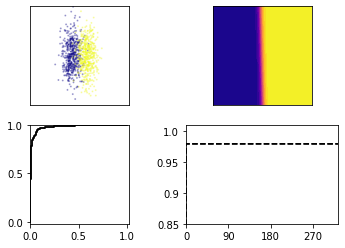

In [64]:
logreg_test = rotatingData2D(
    LogisticRegression(
        penalty='none',
        solver='newton-cg',
        fit_intercept=True),
    sep_dist=3.0
)

log_vid = logreg_test.animate()
HTML(log_vid)

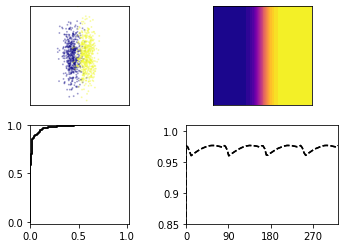

In [65]:
logreg_l1_test = rotatingData2D(
    LogisticRegression(
        penalty='l1',
        C=0.01,
        solver='liblinear',
        fit_intercept=True),
    sep_dist=3.0
)

l1_vid = logreg_l1_test.animate()
HTML(l1_vid)

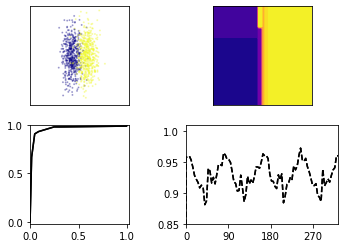

In [66]:
tree_test = rotatingData2D(
    DecisionTreeClassifier(
        max_depth=3),
    sep_dist=3.0
)

tree_vid = tree_test.animate()
HTML(tree_vid)